Taken from
https://github.com/TimKam/py-ciu/blob/master/examples/Random_Forrest_CIU.ipynb

# Setup

In [58]:
from sklearn.ensemble import RandomForestClassifier
from ciu import determine_ciu

In [5]:
# define data generator
import random
import pandas as pd


def classify_case(case):
    """
    Classifies a loan approval case, using a set of rules that include explicit
    gender bias.
    :param case:
    :return: True, if loan should be approved, else False
    """

    if case['gender'] != 'male' and random.random() > 0.5:
        return False
    if case['monthly_income'] > 5000 and case['assets'] > 10000:
        return True

    return False


def generate_data(labelled=True):
    """
    Generates synthetic test/example data: loan application data
    :return: Pandas Dataframe
    """
    data = {
        'age': [],
        'gender': [],
        'assets': [],
        'job_type': [],
        'monthly_income': [],
        'approved': []
    }

    for _ in range(0,2000):
        case = {
            'age': random.randint(20, 70),
            'gender': ['female', 'male', 'other'][random.randint(0, 2)],
            'assets': random.randint(-20000, 150000),
            'job_type': ['fixed', 'permanent', 'none'][random.randint(0, 2)],
            'monthly_income': random.randint(0, 20000)
        }
        case['approved'] = classify_case(case)

        data['age'].append(case['age'])
        data['gender'].append(case['gender'])
        data['assets'].append(case['assets'])
        data['job_type'].append(case['job_type'])
        data['monthly_income'].append(case['monthly_income'])
        if labelled:
            data['approved'].append(case['approved'])

    data_df = pd.DataFrame(data=data)
    data_df_encoded = pd.get_dummies(data_df)
    return {
        'train': [
            data_df[:1000], data_df_encoded[:1000]
        ],
        'test': [
            data_df[-1000:], data_df_encoded[-1000:]
        ]}

# Running CIU

In [7]:
# generate data
data = generate_data()
train_data = data['train'][1]
test_data = data
test_data_encoded = data['test'][1].drop(['approved'], axis=1)


In [9]:
# create and train predictive model
random_forest = RandomForestClassifier(
    n_estimators=1000,
    random_state=42
)

labels = train_data[['approved']].values.ravel()
data = train_data.drop(['approved'], axis=1)
random_forest.fit(data, labels)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [66]:
# choose a particular case to evaluate the CIU
feature_names = list(data.columns)

case_idx = 0
case_row = test_data_encoded[case_idx:case_idx+1]
case = case_row.values
example_prediction = random_forest.predict(case)
example_prediction_prob = random_forest.predict_proba(case)
prediction_index = 0 if example_prediction[0] > 0.5 else 1

print("Case", case_row)
print(f"Prediction:{example_prediction}\nProbability: {example_prediction_prob}")

Case       age  assets  monthly_income  gender_female  gender_male  gender_other  \
1000   52   -3462           17710              0            0             1   

      job_type_fixed  job_type_none  job_type_permanent  
1000               0              0                   1  
Prediction:[False]
Probability: [[0.99 0.01]]


In [67]:
# calculate the CIU
category_mapping = {
    'gender': ['gender_female', 'gender_male', 'gender_other'],
    'job_type': ['job_type_fixed', 'job_type_none', 'job_type_permanent']
}

feature_interactions = [{'assets_income': ['assets', 'monthly_income']}]

ciu = determine_ciu(
    test_data_encoded.iloc[0, :].to_dict(),
    random_forest.predict_proba,
    {
        'age': [20, 70, True],
        'assets': [-20000, 150000, True],
        'monthly_income': [0, 20000, True],
        'gender_female': [0, 1, True],
        'gender_male': [0, 1, True],
        'gender_other': [0, 1, True],
        'job_type_fixed': [0, 1, True],
        'job_type_none': [0, 1, True],
        'job_type_permanent': [0, 1, True]
    },
    1000,
    prediction_index,
    category_mapping,
    feature_interactions
)

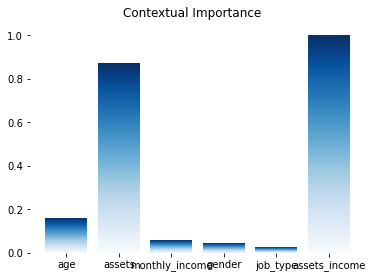

In [68]:
ciu.plot_ci()

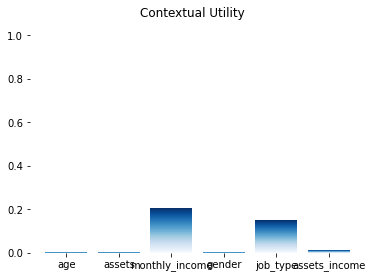

In [69]:
ciu.plot_cu()

In [70]:
print(ciu.text_explain())

['The feature "age", which is not important (CI=15.75%), is not typical for its class (CU=0.1%).', 'The feature "assets", which is highly important (CI=87.18%), is not typical for its class (CU=0.1%).', 'The feature "monthly_income", which is not important (CI=5.87%), is not typical for its class (CU=20.45%).', 'The feature "gender", which is not important (CI=4.41%), is not typical for its class (CU=0.1%).', 'The feature "job_type", which is not important (CI=2.67%), is not typical for its class (CU=15.0%).', 'The feature "assets_income", which is highly important (CI=100.0%), is not typical for its class (CU=1.2%).']
